<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT23/blob/main/template-report-Navier-Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Emil Gestsson, template by Johan Hoffman**

# **Abstract**

Solutions to questions 1-3 in Lab 2, including extra assignment question 3.

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
from scipy import *
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2024-04-16 22:23:58--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2024-04-16 22:23:58 (42.2 MB/s) - ‘/tmp/fenics-install.sh’ saved [4161/4161]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/5182fde/releases/pybind11-inst

# **Introduction**

The Reynolds number is defined as $Re = \frac{UD}{\nu}$ where U, D is characteristic inflow and diameter, and $\nu$ is viscocity. Since the template was written for a fixed U, and changing D would require a recalculation of the mesh, the simplest approach for question 1 is to solve for $\nu$ when testing a desired Reynolds number.

Question 2 can by solved by setting different directions of $\phi$, since in the template its the vector along which force is calculated against. The strouhal number is defined as $St = \frac{fU}{L}$ where f is the vortex frequency, which can be read out from the peak intervals.

Question 3 is simply a comparison of different plots and values, which can be found using the same technique as in question 2.

For extra assignment 3, I import the generated data into ParaView, apply them using a fitting visualization method, and save the animations.


# **Method**

**Define domain and mesh**

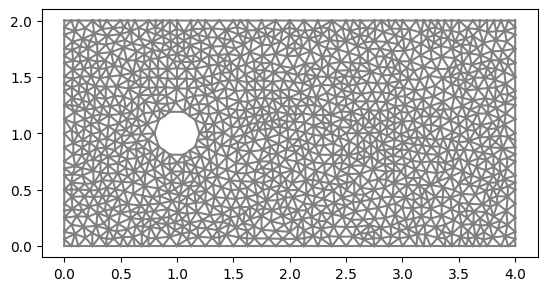

In [57]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [58]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [59]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

**Define flow parameters**

In [60]:
# Set viscosity for specific reynolds number

Re = 100
nu = 2 * rc / Re

# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [61]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In [62]:
# Define the direction of the force to be computed
phi_x = 0.0
phi_y = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

Force_Lift = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx


phi_x = 1.0
phi_y = 0.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)
Force_Drag = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx


#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [63]:
# Open files to export solution to Paraview
#file_u = File("results-NS/u.pvd")
#file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 30
plot_freq = 1

# Force computation data
force_lift_array = np.array(0.0)
force_lift_array = np.delete(force_lift_array, 0)

force_drag_array = np.array(0.0)
force_drag_array = np.delete(force_drag_array, 0)

time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

In [ ]:
#!rm results-NS/*

# Time stepping
T = 30.5
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        FL = assemble(Force_Lift)
        if (t > start_sample_time):
          force_lift_array = np.append(force_lift_array, normalization*FL)
          time = np.append(time, t)

        FD = assemble(Force_Drag)
        if (t > start_sample_time):
          force_drag_array = np.append(force_drag_array, normalization*FD)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        #file_u << u1
        #file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title=f"Velocity (t = {plot_time})")

        plt.figure()
        plot(p1, title=f"Pressure (t = {plot_time})")

        plt.show()

        plt.figure()
        plt.title(f"Drag Force")
        plt.plot(time, force_drag_array)
        plt.show()

        plt.figure()
        plt.title(f"Lift Force")
        plt.plot(time, force_lift_array)
        plt.show()

        plot_time += T/plot_freq

    # Update time step
    u0.assign(u1)
    t += dt

!tar -czvf results-NS.tar.gz results-NS
files.download('results-NS.tar.gz')

**Compute Strouhal number** (must first verify that vortices exit)

In [65]:
peaks = signal.find_peaks(force_lift_array, distance=20, height=0)[0]
peaks = [time[i] for i in peaks]

period = np.median(np.diff(peaks))
print("period: ", period)
print("Strouhal number: ", 2 * rc / period, " if vorteces exit")

period:  2.1027239472962265
Strouhal number:  0.19022944049043497  if vorteces exit


**Compute coefficients**

In [66]:
# use last force as approximate stable force, #rho = 1 D = rc
print(f"drag coffecicient (no vortexes): {force_drag_array[-1] / rc:.5}")
print(f"lift coffecicient (no vortexes): {force_lift_array[-1] / rc:.5}")

# only use last half of data, which should better match convergence
fa_trunc = force_drag_array[len(force_drag_array)//2:]
lo = min(fa_trunc)/ rc
hi = max(fa_trunc)/ rc
print(f"drag coefficient (vortexes): [{lo:.5}, {hi:.5}] = {(lo + hi) / 2:.4} \pm {(hi - lo) / 2:.4}")

fa_trunc = force_lift_array[len(force_lift_array)//2:]
lo = min(fa_trunc)/ rc
hi = max(fa_trunc)/ rc
print(f"lift coefficient (vortexes): [{lo:.5}, {hi:.5}] = {(lo + hi) / 2:.4} \pm {(hi - lo) / 2:.4}")



drag coffecicient (no vortexes): 8.8105
lift coffecicient (no vortexes): 2.0755
drag coefficient (vortexes): [8.3582, 8.8415] = 8.6 \pm 0.2417
lift coefficient (vortexes): [-1.7991, 2.1648] = 0.1828 \pm 1.982


# **Results**

## Question 1

Velocities, pressure and lift force was plotted for each Reynolds number 1, 10, 100 and 1000. From the pressure graph it could be seen that flow was steady at Re=1 and 10, whereas Re=100 and 1000 resulted in what appears to be permanent oscillations and are therefore unsteady.  

For  Re = 1 and 10 a time of T=10 was used. But for Re=100 and 1000 T was extended to 20 to increase confidence in whether, where and how it converged.

### **Re = 1**
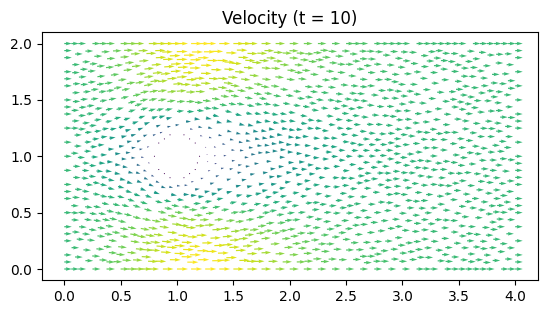 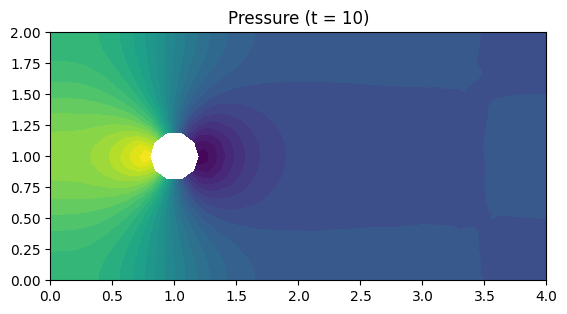 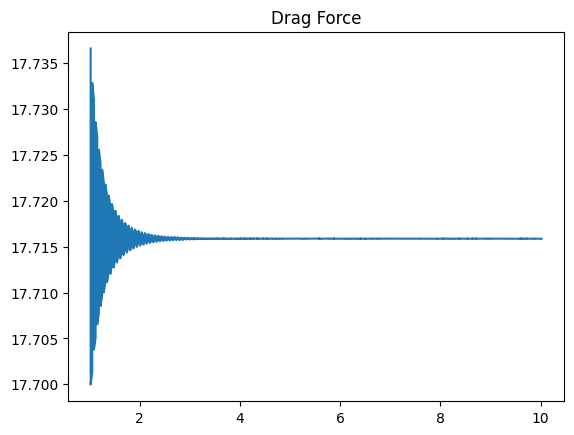

### **Re = 10**
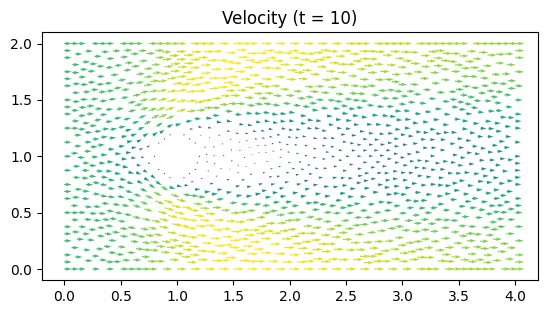 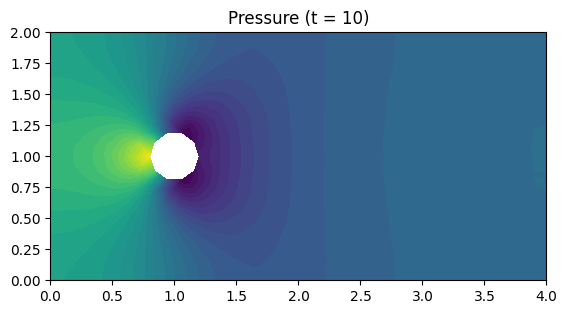 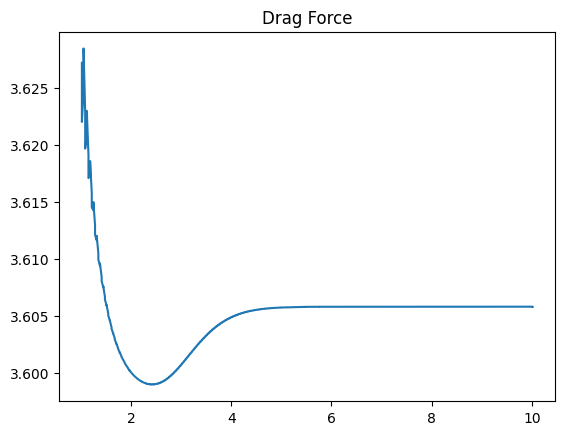

### **Re = 100**

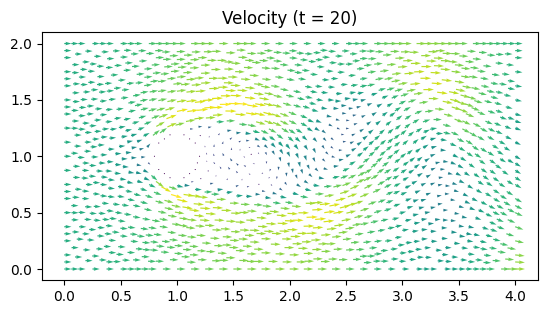 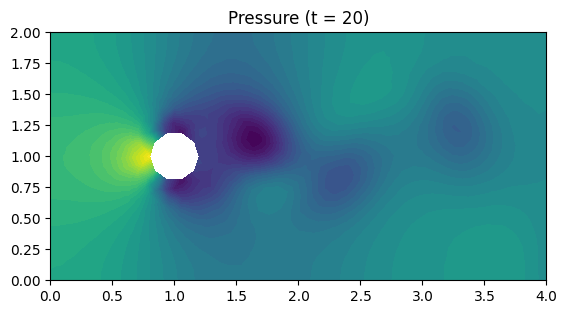 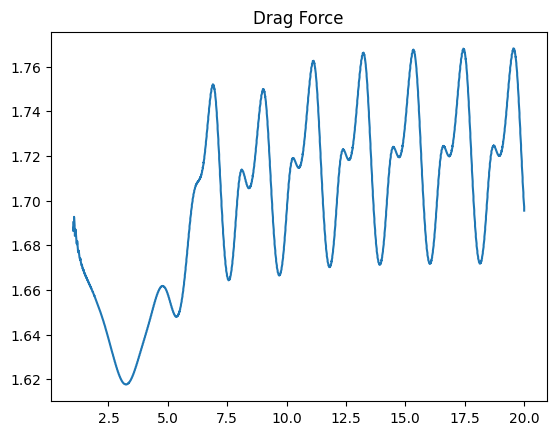

### **Re = 1000**

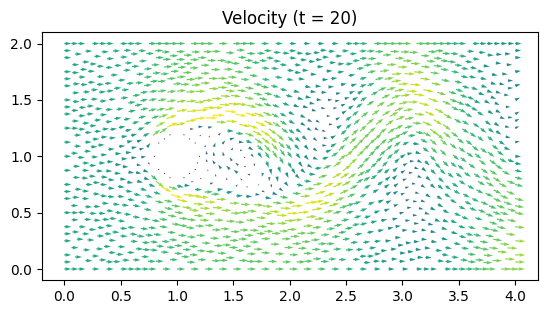 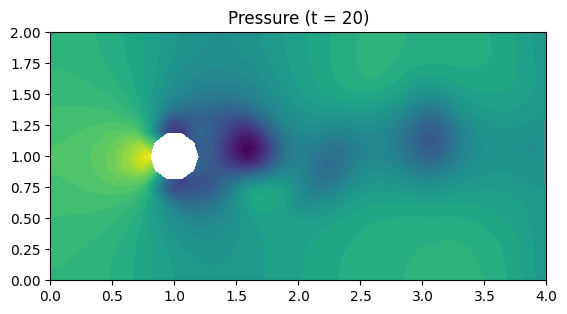 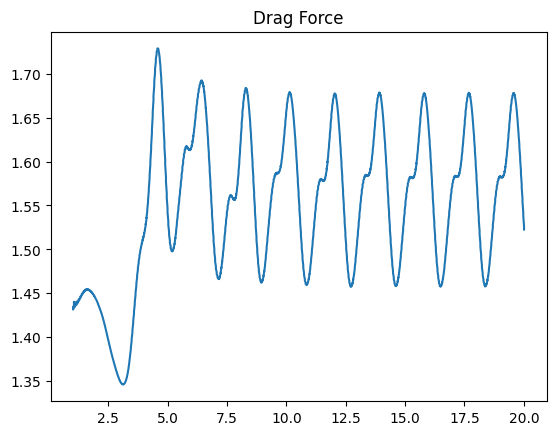

## Question 2


Lift and drag coefficients were calculated using the provided equations (which were greatly simplified since U, $\rho$ = 1), and the Strouhal equation was obtained from [wikipedia](https://en.wikipedia.org/wiki/Strouhal_number)

Frequency and ranges of the force graphs were obtained programmically (see the end of my Method section), mostly because I didnt want to bother with reading values from graphs.

Here are the results:

| $Re$  |  $c_L$   |    $c_D$    |    $St$    |
|----|------------|----------|----|
|1   | 0.1892 | 88.579 | 0  |
|10  | 0.2631  |18.029 | 0  |
|100 | $0.183 \pm 1.98 $  | $8.596 \pm 0.244$  | 0.1902 |
|1000| $0.311 \pm 3.157$  | $0.183 \pm 1.980$      | 0.2135 |

Note that the $\pm$ means they oscillate between the values as they do not have steady flow.


## **Question 3**

Here is a table containing the drag, lift coefficients and Strouhal number for different values of h, with a fixed $Re=100$.

The values were obtained using the method described in question 2. The notable differences is that for the $h=\frac{1}{8}$ case, the solution appeared steady and therefore had a strouhal value of 0 and in the $h=\frac{1}{16}$ case I had to run the simulation until ~T=25 to get a stable oscillation.


| $h$  |  $c_L$   |    $c_D$    |    $St$    |
|----|------------|----------|----|
| $\frac{1}{8}$   | -0.2944 | 14.948 | 0  |
|$\frac{1}{16}$  | $-0.093 \pm 1.094$  |$10.43 \pm 0.083$ | 0.1631  |
|$\frac{1}{32}$ | $0.183 \pm 1.98 $  | $8.596 \pm 0.244$  | 0.1902 |

## **Extra Question 3 (Paraview Visualization)**

I changed the template file to have 900 frames in total, for which T=30 gives 30fps. Glyphs were used to visualize the vector field, and a surface plot was used for pressure.

Here are the results:

[Velocity Visualization](https://youtu.be/tDoQKbJb_PM)

[Pressure Visualization](https://youtu.be/wb3zMtbHVCc)



# **Discussion**